## Dataset Preparation

In [1]:
# Import Dependencies and Define Functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os

def load_dataframes(comb_dict):
    dataframes = {}
    for source, assets in comb_dict.items():
        dataframes[source] = {}
        for asset, timeframes in assets.items():
            dataframes[source][asset] = {}
            for timeframe, info in timeframes.items():
                
                # Read CSV file
                df = pd.read_csv(info['file_path'], parse_dates=True)
                df['open_time'] = pd.to_datetime(df['open_time'])
                df.set_index('open_time', inplace=True)
                dataframes[source][asset][timeframe] = df
                print(f"Loaded {source} {asset} {timeframe} data: {df.shape[0]} rows")
    
    return dataframes

def merge_dataframes(dataframes):
    merged_df = pd.DataFrame()

    for source, assets in dataframes.items():
        for asset, timeframes in assets.items():
            for timeframe, df in timeframes.items():
                merged_df = pd.concat([merged_df, df], axis=1)
                
    return merged_df

In [82]:
# Fetch Data from Binance API and create CSV files
!python binance_scraper.py --coin "BTC,ETH" --interval "1h,1d" --start_time "2020-01-01T20:00:00" --end_time "2025-03-01T20:00:00" --config "./config_indicators.yaml" --save_folder "./data/raw_csvs"

Saved data in "./data/raw_csvs/BTC_1h_from_2020-01-01T20-00-00_to_2025-03-01T20-00-00.csv"
Saved data in "./data/raw_csvs/BTC_1d_from_2020-01-01T20-00-00_to_2025-03-01T20-00-00.csv"
Saved data in "./data/raw_csvs/ETH_1h_from_2020-01-01T20-00-00_to_2025-03-01T20-00-00.csv"
Saved data in "./data/raw_csvs/ETH_1d_from_2020-01-01T20-00-00_to_2025-03-01T20-00-00.csv"


In [2]:
# Copy paste the CSV file paths from the binance_scraper.py output to the comb_dict below
# Example of CSV file paths (these should be replaced with actual paths)    
comb_dict = {
    "binance": {
        "BTC": {
            "1h": {"file_path": "./data/raw_csvs/BTC_1h_from_2020-01-01T20-00-00_to_2025-03-01T20-00-00.csv"},
            "1d": {"file_path": "./data/raw_csvs/BTC_1d_from_2020-01-01T20-00-00_to_2025-03-01T20-00-00.csv"}
        },
        "ETH": {
            "1h": {"file_path": "./data/raw_csvs/ETH_1h_from_2020-01-01T20-00-00_to_2025-03-01T20-00-00.csv"},
            "1d": {"file_path": "./data/raw_csvs/ETH_1d_from_2020-01-01T20-00-00_to_2025-03-01T20-00-00.csv"}
        }
    }
}

In [3]:
dataframes = load_dataframes(comb_dict) # Load dataframes from CSV files

Loaded binance BTC 1h data: 45265 rows
Loaded binance BTC 1d data: 1886 rows
Loaded binance ETH 1h data: 45265 rows
Loaded binance ETH 1d data: 1886 rows


In [4]:
# Resample DataFrames to merge different timeframes
dataframes["binance"]["BTC"]["1d"] = dataframes["binance"]["BTC"]["1d"].resample("1h").ffill().shift(24)
dataframes["binance"]["ETH"]["1d"] = dataframes["binance"]["ETH"]["1d"].resample("1h").ffill().shift(24)

In [5]:
merged_df = merge_dataframes(dataframes) # Merge all dataframes into one
merged_df.dropna(inplace=True) # Drop rows with NaN values

merged_df.insert(0, 'weekday', merged_df.index.weekday) # Add weekday column
merged_df.insert(1, 'hour', merged_df.index.hour) # Add hour column

save_path = "./data/dataset"
os.makedirs(save_path, exist_ok=True)
merged_df.to_csv(os.path.join(save_path, "merged_df.csv")) # Save merged dataframe to CSV

In [ ]:
# Save as final dataset as .npy files
price_column = "close_1h_ETH"

close_price_index = merged_df.columns.get_loc(price_column)
price_array = np.array(merged_df.iloc[:, close_price_index])
price_array = np.expand_dims(price_array.astype(np.float32), axis=1)

tech_array = np.array(merged_df).astype(np.float32)

print("price_array shape:", price_array.shape)
print("tech_array shape:", tech_array.shape)

np.save(os.path.join(save_path, "price_outfile.npy"), price_array)
np.save(os.path.join(save_path, "metrics_outfile.npy"), tech_array)

price_array shape: (44425, 1)
tech_array shape: (44425, 74)


In [88]:
print(merged_df.columns)
print('\n', merged_df.shape)

Index(['weekday', 'hour', 'open_1h_BTC', 'high_1h_BTC', 'low_1h_BTC',
       'close_1h_BTC', 'volume_1h_BTC', 'ADX_14_1h_BTC', 'DMP_14_1h_BTC',
       'DMN_14_1h_BTC', 'ATRr_14_1h_BTC', 'BBL_20_2.0_1h_BTC',
       'BBM_20_2.0_1h_BTC', 'BBU_20_2.0_1h_BTC', 'BBB_20_2.0_1h_BTC',
       'BBP_20_2.0_1h_BTC', 'MACD_12_26_9_1h_BTC', 'MACDh_12_26_9_1h_BTC',
       'MACDs_12_26_9_1h_BTC', 'RSI_14_1h_BTC', 'open_1d_BTC', 'high_1d_BTC',
       'low_1d_BTC', 'close_1d_BTC', 'volume_1d_BTC', 'ADX_14_1d_BTC',
       'DMP_14_1d_BTC', 'DMN_14_1d_BTC', 'ATRr_14_1d_BTC', 'BBL_20_2.0_1d_BTC',
       'BBM_20_2.0_1d_BTC', 'BBU_20_2.0_1d_BTC', 'BBB_20_2.0_1d_BTC',
       'BBP_20_2.0_1d_BTC', 'MACD_12_26_9_1d_BTC', 'MACDh_12_26_9_1d_BTC',
       'MACDs_12_26_9_1d_BTC', 'RSI_14_1d_BTC', 'open_1h_ETH', 'high_1h_ETH',
       'low_1h_ETH', 'close_1h_ETH', 'volume_1h_ETH', 'ADX_14_1h_ETH',
       'DMP_14_1h_ETH', 'DMN_14_1h_ETH', 'ATRr_14_1h_ETH', 'BBL_20_2.0_1h_ETH',
       'BBM_20_2.0_1h_ETH', 'BBU_20_2.0_1h_ET

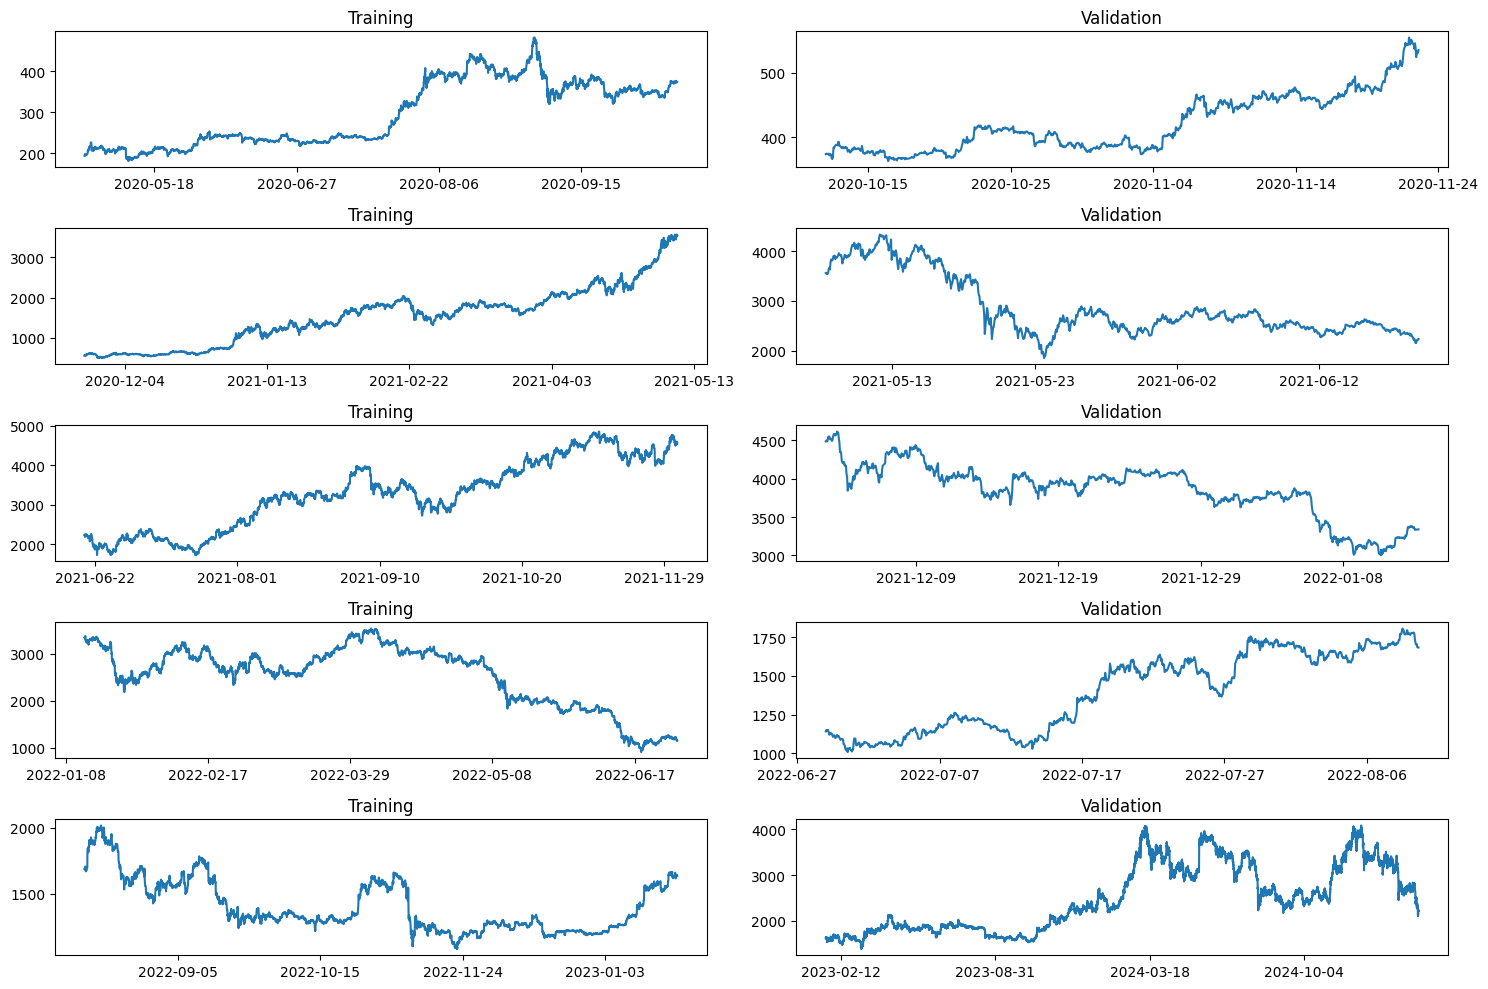

In [89]:
# Visualize training and validation intervals
register_matplotlib_converters()

# choose intervals for training and validation
# training/validation split is 80/20
data_frames = [
                merged_df.iloc[2000:6000, [close_price_index]], merged_df.iloc[6000:7000, [close_price_index]],
                merged_df.iloc[7000:11000, [close_price_index]], merged_df.iloc[11000:12000, [close_price_index]],
                merged_df.iloc[12000:16000, [close_price_index]], merged_df.iloc[16000:17000, [close_price_index]],
                merged_df.iloc[17000:21000, [close_price_index]], merged_df.iloc[21000:22000, [close_price_index]],
                merged_df.iloc[22000:26000, [close_price_index]], merged_df.iloc[26000:, [close_price_index]]
                ]


fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 10))
axs = axs.flatten()  # Flatten to make it easier to iterate

# Plot each DataFrame in its subplot
for i, (ax, df) in enumerate(zip(axs, data_frames)):
    # ax.plot(df.index, df['Value'])
    ax.plot(df.index, df[price_column])

    if i % 2 == 0:
        ax.set_title('Training')
    else:
        ax.set_title('Validation')

    # Optional: Format the x-axis with specific date formatting
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Limit number of ticks

# Automatically adjust plot parameters to give room and prevent overlap
plt.tight_layout()
plt.show()

### Plotting some examples to compare to TradingView

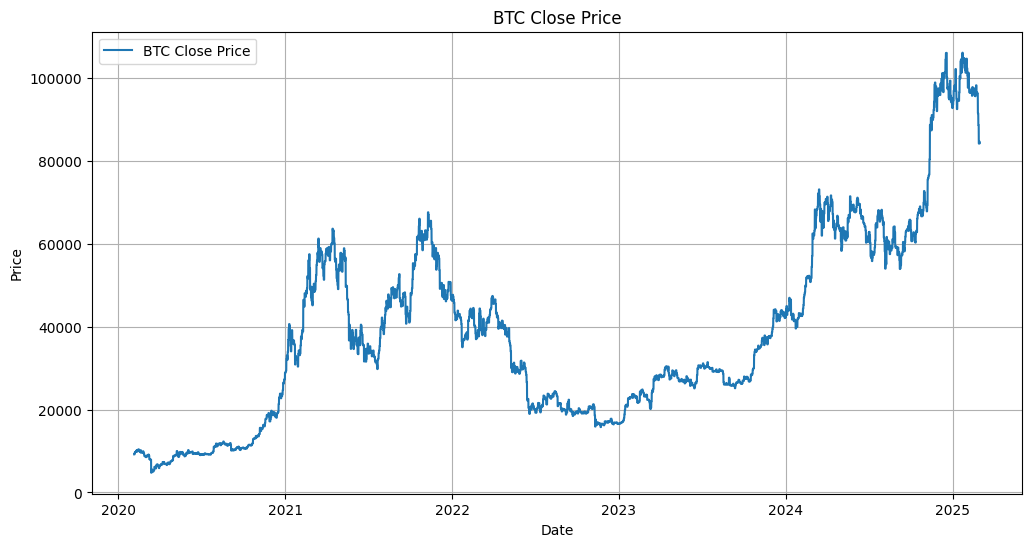

In [90]:
# Plot BTC close price
plt.figure(figsize=(12, 6))
plt.plot(merged_df['close_1d_BTC'], label='BTC Close Price')
plt.title('BTC Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()

plt.show()

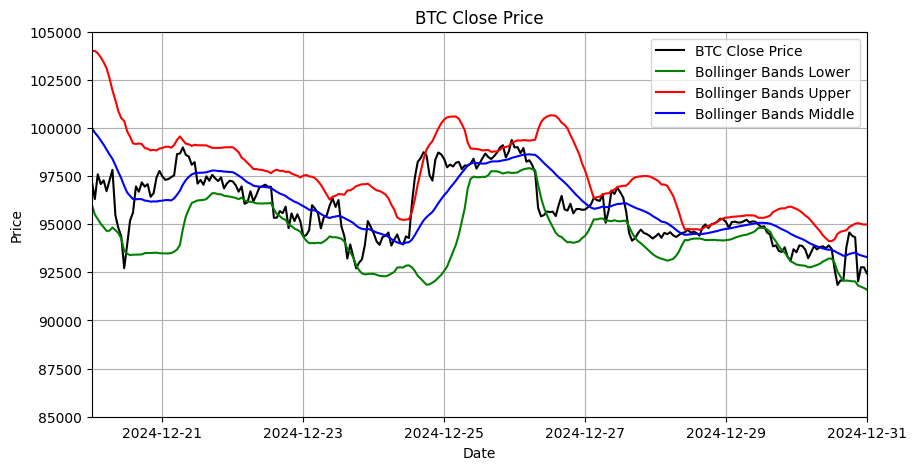

In [91]:
# Plot BTC close price
plt.figure(figsize=(10, 5))
plt.plot(merged_df['close_1h_BTC'], label='BTC Close Price', color='black')
plt.plot(merged_df['BBL_20_2.0_1h_BTC'], label='Bollinger Bands Lower', color='green')
plt.plot(merged_df['BBU_20_2.0_1h_BTC'], label='Bollinger Bands Upper', color='red')
plt.plot(merged_df['BBM_20_2.0_1h_BTC'], label='Bollinger Bands Middle', color='blue')
plt.title('BTC Close Price')
plt.xlabel('Date')
plt.xlim(pd.to_datetime('2024-12-20'), pd.to_datetime('2024-12-31'))
plt.ylabel('Price')
plt.ylim(85000, 105000)
plt.legend()
plt.grid()

plt.show()

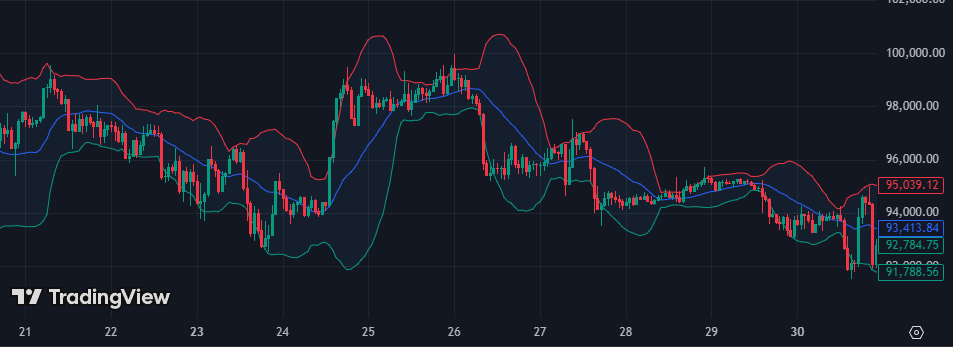

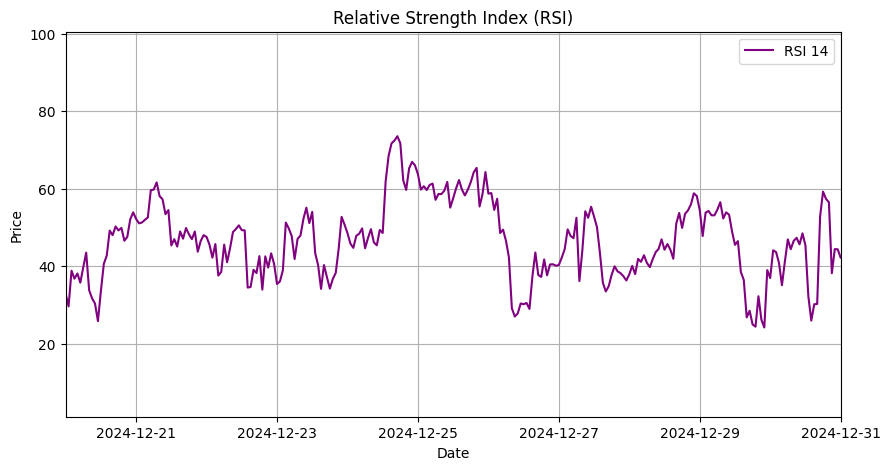

In [92]:
# Plot BTC RSI 14
plt.figure(figsize=(10, 5))
plt.plot(merged_df['RSI_14_1h_BTC'], label='RSI 14', color='purple')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.xlim(pd.to_datetime("2024-12-20"), pd.to_datetime("2024-12-31"))
plt.ylabel('Price')
plt.legend()
plt.grid()

plt.show()

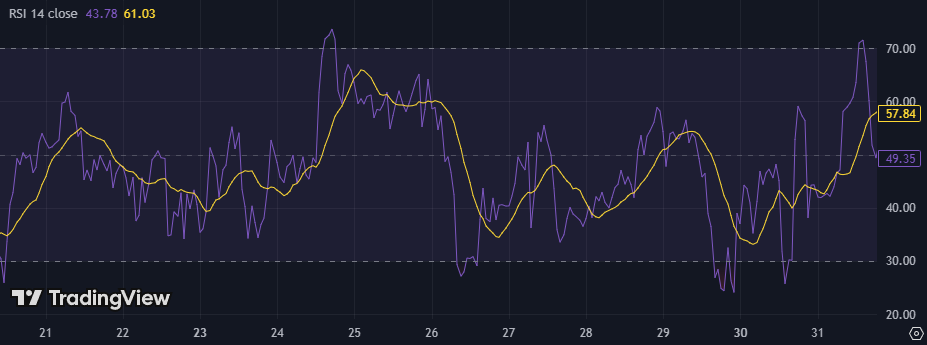

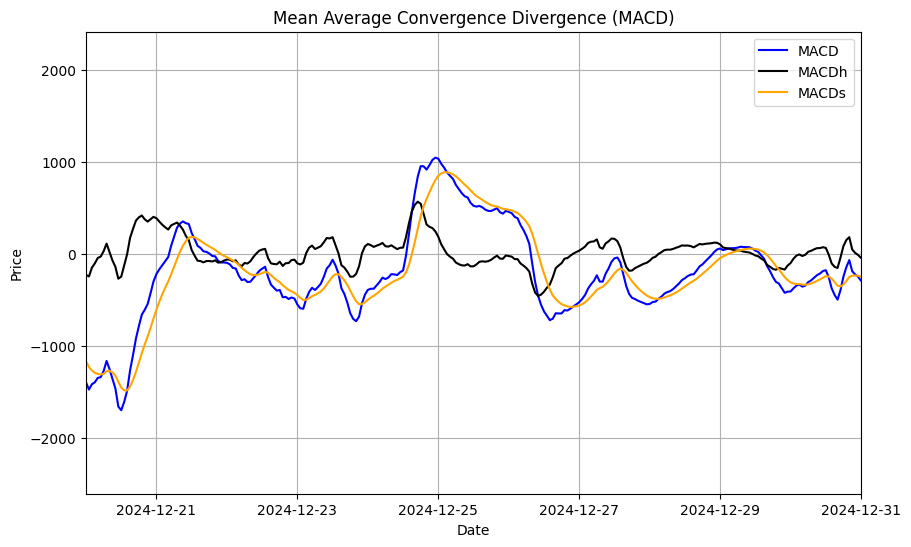

In [93]:
# Plot BTC MACD 12_26_9
plt.figure(figsize=(10, 6))
plt.plot(merged_df['MACD_12_26_9_1h_BTC'], label='MACD', color='blue')
plt.plot(merged_df['MACDh_12_26_9_1h_BTC'], label='MACDh', color='black')
plt.plot(merged_df['MACDs_12_26_9_1h_BTC'], label='MACDs', color='orange')
plt.title('Mean Average Convergence Divergence (MACD)')
plt.xlabel('Date')
plt.xlim(pd.to_datetime("2024-12-20"), pd.to_datetime("2024-12-31"))
plt.ylabel('Price')
plt.legend()
plt.grid()

plt.show()

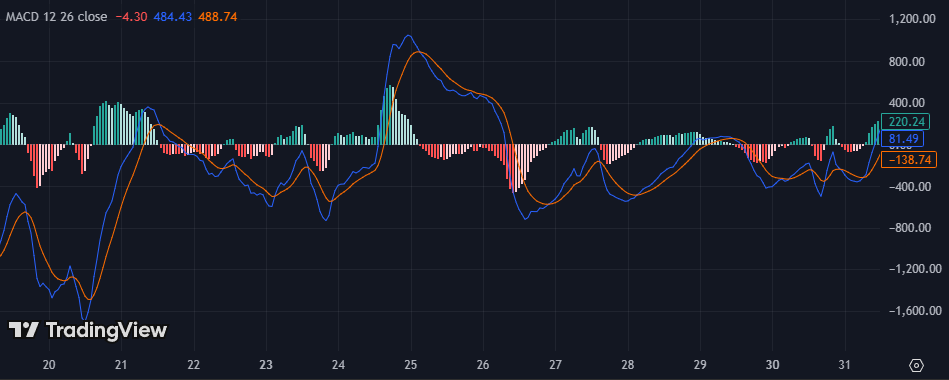